In [3]:
import tensorflow as tf
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt



In [10]:
import os, cv2, numpy as np
DATA_PATH = '/kaggle/input/leapgestrecog/leapGestRecog'
if not os.path.exists(DATA_PATH): raise FileNotFoundError(f"Dataset not found at {DATA_PATH}")
images, labels = [], []
for class_idx, class_folder in enumerate(sorted(os.listdir(DATA_PATH))):
    class_dir = os.path.join(DATA_PATH, class_folder)
    if not os.path.isdir(class_dir): print(f"Skipping non-directory item: {class_folder}"); continue
    for root, _, files in os.walk(class_dir):
        for img_name in files:
            if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')): continue
            img_path = os.path.join(root, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None: print(f"Could not load image: {img_path}"); continue
            try: img = cv2.resize(img, (64, 64)); images.append(img); labels.append(class_idx)
            except Exception as e: print(f"Error processing image {img_path}: {e}")
if not images: raise RuntimeError("No images were successfully loaded. Check dataset structure or file paths.")
images, labels = np.array(images), np.array(labels)
print(f"Successfully loaded {len(images)} images with labels.")


Successfully loaded 20000 images with labels.


In [12]:

# Convert to numpy arrays
X = np.array(images)
y = np.array(labels)

# Preprocess the data
X = X / 255.0  # Normalize pixel values
X = X.reshape(-1, 64, 64, 1)  # Reshape for CNN
y = to_categorical(y, 10)  # One-hot encode labels

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

# Create the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), input_shape=(64, 64, 1) ,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Training samples: 16000
Testing samples: 4000


In [13]:

# Add callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
]

# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=15,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest accuracy: {test_accuracy:.4f}")

# Save the model
model.save('leap_gesture_model.h5')

Epoch 1/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 77s 149ms/step - accuracy: 0.6903 - loss: 1.2033 - val_accuracy: 0.3145 - val_loss: 8.8326 - learning_rate: 0.0010
Epoch 2/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 73s 147ms/step - accuracy: 0.9758 - loss: 0.0624 - val_accuracy: 0.9660 - val_loss: 0.1071 - learning_rate: 0.0010
Epoch 3/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 72s 144ms/step - accuracy: 0.9793 - loss: 0.0565 - val_accuracy: 0.9898 - val_loss: 0.0333 - learning_rate: 0.0010
Epoch 4/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 73s 145ms/step - accuracy: 0.9874 - loss: 0.0325 - val_accuracy: 0.9875 - val_loss: 0.0276 - learning_rate: 0.0010
Epoch 5/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 74s 148ms/step - accuracy: 0.9849 - loss: 0.0328 - val_accuracy: 0.9900 - val_loss: 0.0155 - learning_rate: 0.0010
Epoch 6/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 73s 146ms/step - accuracy: 0.9880 - loss: 0.0306 - val_accuracy: 0.9908 - val_loss: 0.0148 - learning_rate: 0.0010
Epoch 7/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 74s 148ms/step - accuracy: 0.9

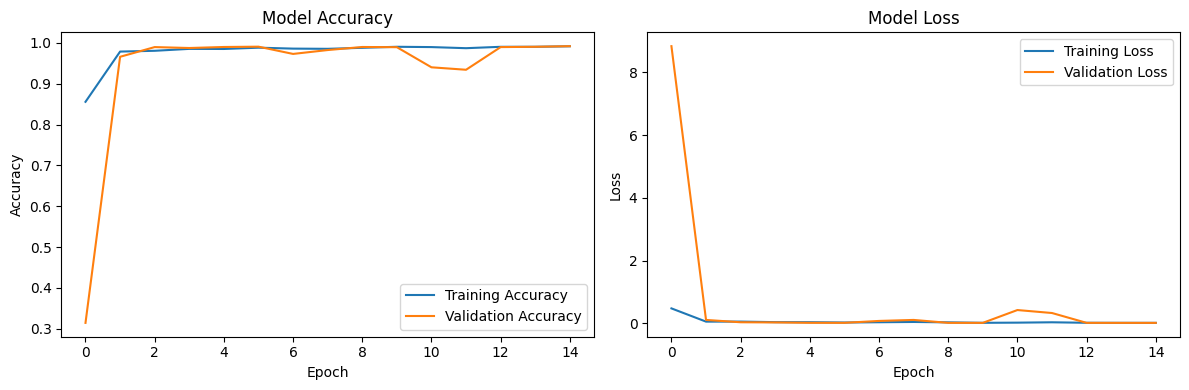

125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step


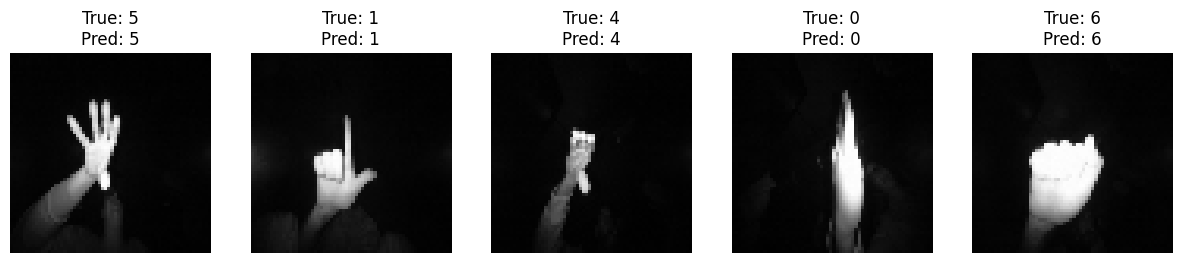

In [14]:

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Make predictions on test data
predictions = model.predict(X_test)

# Display some example predictions
def display_predictions(X_test, y_test, predictions, num_images=5):
    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(X_test[i].reshape(64, 64), cmap='gray')
        true_label = np.argmax(y_test[i])
        pred_label = np.argmax(predictions[i])
        plt.title(f'True: {true_label}\nPred: {pred_label}')
        plt.axis('off')
    plt.show()

display_predictions(X_test, y_test, predictions)